In [1]:
# Libraries for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette('viridis')

# Parameters for the visualizations
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# For easy computation over certain datasets
import numpy as np
np.set_printoptions(suppress=True)

# Pyspark utilities
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

# Execution mode:
# Cluster = -1
# Local >= 1 (i.e., number of files to load)

EXEC_MODE = 1
cloud = False

# TODO
from lib import *

# start spark with 1 worker thread
sc = init()
sc.setLogLevel("ERROR")

# Start SparkSession to use DataFrames
spark = SparkSession(sc)

In [2]:
# Get the machine_events table from the GCloud bucket and use it with spark
machine_events = Table('machine_events', sc, EXEC_MODE, cloud)
machine_events.pprint(take=5)

,time,machine_id,event_type,platform_id,cpus,memory
0,0,5,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
1,0,6,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
2,0,7,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
3,0,10,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493
4,0,13,0,HofLGzk1Or/8Ildj2+Lqv0UGGvY82NLoni8+J/Yy0RU=,0.5,0.2493


In [3]:
# Same as above, load a part of the table in memory and use it.
task_events = Table('task_events', sc, EXEC_MODE, cloud)
task_events.pprint(3)

,time,missing_info,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machines_restriction
0,5611824441,NA,6251812952,1761,1306108,4,fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=,0,2,0.02499,0.07959,0.0003862,1
1,5611824625,NA,6251974185,252,38676295,4,fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=,0,2,0.02499,0.03339,0.0003862,1
2,5612587437,NA,6251995937,33,386450501,2,4Ubmtvv/epOnUEgegvGV9mCxxcZkV4z/Dm8RY/9SEYw=,0,0,0.06873,0.01193,0.0001154,0


In [4]:
task_usage = Table('task_usage', sc, EXEC_MODE, cloud)
task_usage.pprint(5)

,start_time,end_time,job_id,task_index,machine_id,cpu_rate,canonical_memory_usage,assigned_memory_usage,unmapped_page_cache,total_page_cache,maximum_memory_usage,disk_i/o_time,local_disk_space_usage,maximum_cpu_rate,maximum_disk_io_time,cycles_per_instruction,memory_accesses_per_instruction,sample_portion,aggregation_type,sampled_cpu_usage
0,600000000,900000000,3418309,0,4155527081,0.001562,0.06787,0.07568,0.001156,0.001503,0.06787,2.861e-06,0.0001869,0.03967,0.0003567,2.445,0.007243,0,1,0
1,600000000,900000000,3418309,1,329150663,0.001568,0.06787,0.07556,0.0003195,0.0007,0.06787,5.722e-06,0.0001879,0.03302,0.0009289,2.1,0.005791,0,1,0
2,600000000,900000000,3418314,0,3938719206,0.0003071,0.08044,0.09521,0.0002823,0.0006704,0.08044,4.768e-06,0.0001841,0.02377,0.0007858,5.588,0.0208,0,1,0
3,600000000,900000000,3418314,1,351618647,0.0003004,0.08044,0.09521,0.0005369,0.0008698,0.08044,9.537e-06,0.0001831,0.007919,0.002285,5.198,0.02038,0,1,0
4,600000000,900000000,3418319,0,431052910,0.0004606,0.07715,0.0874,0.0006247,0.0008516,0.07715,1.907e-06,0.0002041,0.005112,0.0002146,2.937,0.009449,0,1,0


In [10]:
# Select first SUBMIT transition for each job
submit_status = task_events.select(['job_id','task_index','event_type', 'time'])\
    .filter(lambda x: x[2] in ['0'])

# Take the earliest time recorded - Start of pending
rdd_submit = submit_status.map(lambda x: (x[0]+', '+x[1], int(x[3]))).reduceByKey(lambda a, b: min(a, b))
rdd_submit.take(20)

[('6221861800, 17100', 0),
 ('6251995937, 367', 5142502281),
 ('6251995937, 280', 5142502107),
 ('5912313637, 16', 0),
 ('6251995937, 458', 5142502463),
 ('6251995937, 1014', 5142503575),
 ('6221861800, 15556', 0),
 ('6218406404, 1146', 0),
 ('6218406404, 1143', 0),
 ('6218406404, 1138', 0),
 ('6218406404, 1062', 0),
 ('6251995937, 761', 5142503069),
 ('4392480606, 209', 0),
 ('515042969, 3', 0),
 ('6218406404, 1098', 0),
 ('6238340468, 2133', 0),
 ('6221861800, 4010', 0),
 ('6249834537, 496', 0),
 ('6114773114, 469', 0),
 ('6183750753, 82', 0)]

In [11]:
# Select first SUBMIT transition for each job
outpending_status = task_events.select(['job_id','task_index','event_type', 'time'])\
    .filter(lambda x: x[2] in ['1', '3', '5', '6'])

# Take the earliest time recorded - End of pending
rdd_outpending = outpending_status.map(lambda x: (x[0]+', '+x[1], int(x[3]))).reduceByKey(lambda a, b: min(a, b))
rdd_outpending.take(20)

[('4923128384, 22', 0),
 ('6252020264, 12', 5616660432),
 ('6252020264, 75', 5618148982),
 ('6252020264, 19', 5618176812),
 ('6252020264, 3', 5618177078),
 ('6252020264, 11', 5618177732),
 ('6252020264, 33', 5618836970),
 ('6252020264, 30', 5619528198),
 ('6252020264, 82', 5621046330),
 ('4392480606, 209', 0),
 ('515042969, 3', 0),
 ('6252020264, 47', 5621081754),
 ('6252020264, 43', 5623573006),
 ('6252020264, 26', 5626016706),
 ('6252020264, 44', 5628143646),
 ('6252020264, 109', 5628803592),
 ('6252020264, 29', 5629483768),
 ('6252010250, 0', 5286999682),
 ('6252020264, 42', 5633005985),
 ('6252020264, 48', 5636924920)]

In [12]:
rdd_deltatimes = rdd_submit.join(rdd_outpending).map(lambda x: (x[0], x[1][1] - x[1][0]))

rdd_deltatimes.take(20)

[('6221861800, 17100', 0),
 ('6251995937, 367', 2331391),
 ('6251995937, 280', 2328616),
 ('5912313637, 16', 0),
 ('6251995937, 458', 2334095),
 ('6251995937, 1014', 2350884),
 ('6221861800, 15556', 0),
 ('6218406404, 1146', 0),
 ('6218406404, 1143', 0),
 ('6218406404, 1138', 2097670924),
 ('6218406404, 1062', 0),
 ('6251995937, 761', 2343212),
 ('4392480606, 209', 0),
 ('515042969, 3', 0),
 ('6218406404, 1098', 0),
 ('6238340468, 2133', 0),
 ('6221861800, 4010', 0),
 ('6249834537, 496', 0),
 ('6114773114, 469', 0),
 ('6183750753, 82', 0)]

In [16]:
# Take only job ids and delta times
rdd_deltatimes_avg_stage1 = rdd_deltatimes.map(lambda x: (x[0].split(', ')[0], x[1]))

# Compute the average delta time for each job
avg_init = (0, 0)
rdd_deltatimes_avg_stage2 = rdd_deltatimes_avg_stage1.aggregateByKey(avg_init, lambda a,b: (a[0] + b,    a[1] + 1),
                                       lambda a,b: (a[0] + b[0], a[1] + b[1]))
rdd_deltatimes_avg = rdd_deltatimes_avg_stage2.mapValues(lambda v: v[0]/v[1])


rdd_deltatimes_avg.take(20)

[('6114773114', 0.0),
 ('6252020538', 2679777.2195121953),
 ('6252024742', 838941.1818181818),
 ('6251501988', 1414804.0),
 ('6252025974', 1649972.0),
 ('6252026716', 2163724.0),
 ('6252027974', 2179157.6666666665),
 ('6176858948', 0.0),
 ('6252031834', 810525.5),
 ('4028922835', 0.0),
 ('6252034116', 1491733.0),
 ('6252036505', 1488270.0),
 ('6252036503', 1485285.0),
 ('6252037581', 1453483.0),
 ('6252041355', 1028605.0),
 ('6252041679', 740710.4375),
 ('6251980656', 778301.82),
 ('6252042114', 1379982.7833333334),
 ('6252042334', 1158193.4896907217),
 ('6252042628', 1163577.8298969073)]

In [20]:
# Load the task_constraints table
task_constraints = Table('task_constraints', sc, EXEC_MODE, cloud)

# Selects each occurence of constraint registered for each process
task_constraints_per_jobtask = task_constraints.select(['job_id', 'task_index', 'time']).map(lambda x: ((x[0],x[1]), x[2]))

# Init, merge and combine functions for the combineByKey
def avg_init(row):
    return [1]

def avg_merge(old, new):
    return [old[0]+1]

def avg_cmb(old, new):
    return [old[0]+new[0]]

# Counts the total number of constraints for each process
rdd_number_task_constraints_per_jobtask = task_constraints_per_jobtask.combineByKey(avg_init, avg_merge, avg_cmb).map(lambda x: ((x[0][0]), x[1][0]))

# Do the average of nb_constraints for each job
avg_init = (0, 0)
rdd_number_task_constraints_per_job_avg_stage1 = rdd_number_task_constraints_per_jobtask.aggregateByKey(avg_init, lambda a,b: (a[0] + b, a[1] + 1),
                                       lambda a,b: (a[0] + b[0], a[1] + b[1]))
rdd_number_task_constraints_per_job_avg = rdd_number_task_constraints_per_job_avg_stage1.mapValues(lambda v: int(v[0]/v[1]))

# Join the delta time and the number of constraints in one RDD
rdd_delta_constraints = rdd_deltatimes_avg.join(rdd_number_task_constraints_per_job_avg).filter(lambda x: x[1][1] < 50)

rdd_delta_constraints.take(20)


[('6238842343', (0.0, 4)),
 ('6238839290', (0.0, 4)),
 ('3998352223', (0.0, 1)),
 ('3418442', (0.0, 2)),
 ('6590376', (0.0, 4)),
 ('98680993', (0.0, 2)),
 ('260194510', (0.0, 2)),
 ('986962601', (0.0, 1)),
 ('1393056113', (0.0, 2)),
 ('1930851759', (0.0, 2)),
 ('2024770216', (0.0, 2)),
 ('2780814322', (0.0, 2)),
 ('3176007645', (0.0, 1)),
 ('3244832720', (0.0, 2)),
 ('3673031028', (0.0, 2)),
 ('3811215646', (0.0, 2)),
 ('4202070514', (0.0, 1)),
 ('4391105601', (0.0, 1)),
 ('4537387277', (0.0, 1)),
 ('4923136192', (0.0, 2))]

Text(0.5, 1.0, 'Time spent on PENDING state depending on the number of constraints')

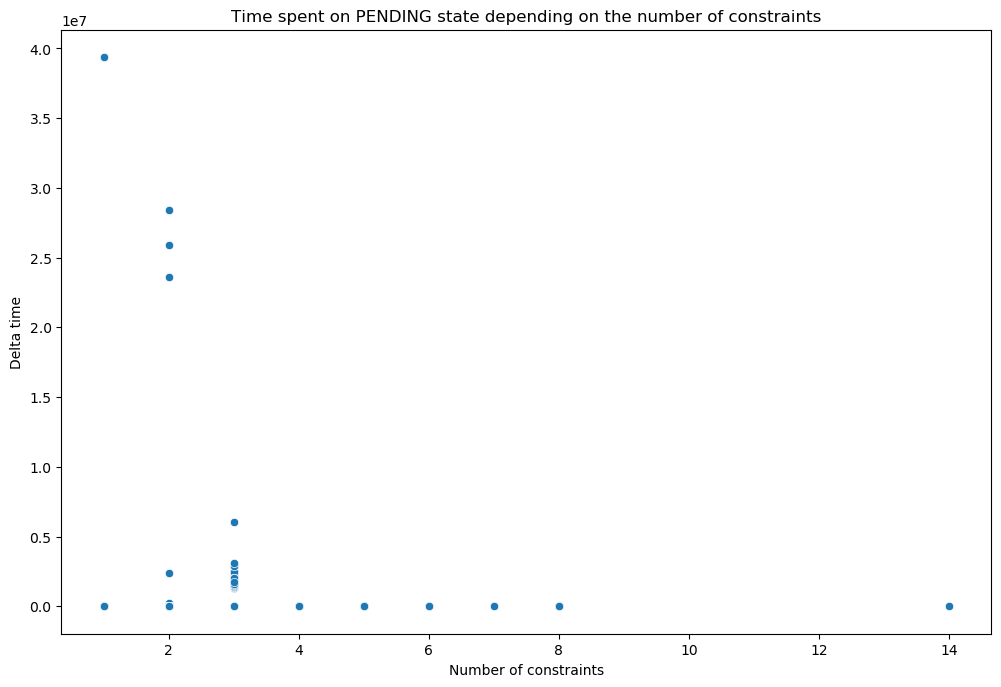

In [21]:
# Create the list of values from the last RDD
rdd_to_map = rdd_delta_constraints.collectAsMap()
deltatimes = [v[0] for v in rdd_to_map.values()]
constraints = [v[1] for v in rdd_to_map.values()]

# And then pass it to seaborn to create a barplot to have a global view
g = sns.scatterplot(x=constraints, y=deltatimes)

g.set_xlabel("Number of constraints")
g.set_ylabel("Delta time")

g.set_title("Time spent on PENDING state depending on the number of constraints")